In [52]:
%matplotlib inline

In [196]:
from lab_tsp_insertion import *
import math
import matplotlib.pyplot as plt
import sys

In [213]:
from functools import lru_cache
class TSPSolution(object):
    def __init__(self, instance: list, tour:list, distance:int):
        self.tour = tour
        self.n_cities = len(tour)
        self.inst = instance
        self.distance = self.calculate_solution_distance()
    
    def __repr__(self):
        return f"Tour={self.tour}, distance={self.distance}, n_cities={self.n_cities}"
    
    def get_n_cities(self):
        return self.n_cities
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def get_distance(self, x, y):
        # This function takes the city number, not index into array
        c1x, c1y = self.inst[x]
        c2x, c2y = self.inst[y]
        return ((c2x - c1x) ** 2 + (c2y - c1y) ** 2)
    
    def copy(self):
        return TSPSolution(self.inst, self.tour.copy(), self.distance)
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def is_valid_swap(self, x:int, y:int):
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        return x != y and x != y1 and x != x1 and y != y1 and y != x1 and y1 != x1
    
    def calculate_cost_if_swapped(self, x:int, y: int):
        # If the edges are swapped what would be the cost
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        xx1 = self.get_distance(self.tour[x], self.tour[x1])
        xy = self.get_distance(self.tour[x], self.tour[y])
        yy1 = self.get_distance(self.tour[y], self.tour[y1])
        x1y1 = self.get_distance(self.tour[x1], self.tour[y1])
        return self.distance - xx1 - yy1 + x1y1 + xy
    
    def get_cache_stats(self):
        return self.get_distance.cache_info(), self.is_valid_swap.cache_info()
    
    def calculate_solution_distance(self):
        dist = 0
        for x in range(self.n_cities):
            y = (x + 1) % self.n_cities
            dist += self.get_distance(self.tour[x], self.tour[y])
        return dist
    
    def perform_swap(self, x, y):
        x, y = min(x, y), max(x, y)
        new_distance = self.calculate_cost_if_swapped(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        assert(x1 < y)
        self.tour[x1], self.tour[y] = self.tour[y], self.tour[x1]
        i = x1 + 1
        j = y - 1
        while (i < j):
            self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
            i += 1
            j -= 1
        #if int(self.calculate_solution_distance()) != int(new_distance):
        #    print(f"New distance should have been {new_distance} but is {self.calculate_solution_distance()}")
        self.distance = new_distance


In [258]:
class TSPHillClimbing(object):
    def __init__(self, inst:dict = None, max_sideways_moves:int=0, description:str="None",\
                time_plot=None, distance_plot=None, distance_time_plot=None, verbose:bool=False,\
                use_random_heuristic:bool=False):
        self.inst = inst
        self.ind = None
        self.g_best_solution = None
        self.g_best_distance = 99999999999999999999999999999999999999999
        self.current_iter_sols = []
        self.current_iter_dist = None
        self.max_sideways_moves = max_sideways_moves
        self.n_sideways_moves = 0
        self.g_best_distance = 999999999999999999999999999999999999999999
        self.g_best_sol = None
        self.last_improving_iteration = -1
        self.iteration = -1
        self.figure = None
        self.time_plot = time_plot
        self.distance_plot = distance_plot
        self.n_restart = -1
        self.description = description
        self.verbose = verbose
        self.distance_time_plot = distance_time_plot
        self.use_random_heuristic = use_random_heuristic
        if None != self.inst:
            self.ind = self.get_solution()
            self.update_best_g_instance(self.ind)

            
    def __repr__(self):
        return f"inst = {self.inst}\n\nindividual = {self.ind}\n\n" +\
             f"g_best_solution = {self.g_best_solution}\n\ng_best_distance = {self.g_best_distance}"
    
    def update_best_g_instance(self, instance: TSPSolution):
        if self.g_best_distance > instance.distance:
            self.g_best_solution = instance.copy()
            self.g_best_distance = instance.distance
        
    def get_solution(self):
        if not self.use_random_heuristic:
            cities, distance = insertion_heuristic1(self.inst)
        else:
            cities, distance = randomTours(self.inst)
        return TSPSolution(self.inst, cities, distance)
    
    def check_improving_move(self):
        self.current_iter_dist = self.ind.distance
        self.current_iter_sols = []
        for i in range(self.ind.get_n_cities()):
            for j in range(i+2, self.ind.get_n_cities()):
                if not self.ind.is_valid_swap(i, j):
                    pass
                else:
                    newcost = self.ind.calculate_cost_if_swapped(i, j)
                    if newcost == self.current_iter_dist:
                        self.current_iter_sols.append(list(i, j))
                    elif newcost < self.current_iter_dist:
                        self.current_iter_dist = newcost
                        self.current_iter_sols = [[i,j]]
    
    def iterate_once(self, allow_sideways=False):
        update = False
        old_distance = self.ind.distance
        self.check_improving_move()
        if old_distance == self.current_iter_dist:
            if not allow_sideways or len(self.current_iter_sols) == 0:
                #print("No moves possible")
                return old_distance, self.current_iter_dist, True
            else:
                if self.verbose:
                    print("Performing sideways move", self.n_sideways_moves + 1)
                self.n_sideways_moves += 1
                update = True
        if int(self.ind.distance) > int(self.current_iter_dist):
            self.last_improving_iteration = self.iteration
            self.n_sideways_moves = 0
            update = True
        if update:
            toswap = self.current_iter_sols[random.randint(0, len(self.current_iter_sols)-1)]
            x, y = tuple(toswap)
            self.ind.perform_swap(x, y)
            self.update_best_g_instance(self.ind)
        return old_distance, self.current_iter_dist, False
        
    def iterate(self, n_iterations, allow_sideways=False, max_sideways_moves=-1):
        y = []
        rt = []
        iters_list = []
        self.n_sideways_moves = 0
        self.last_improving_iteration = 0
        t1 = time.perf_counter()
        for self.iteration in range(n_iterations):
            if self.verbose:
                sys.stdout.write('-')
            old_distance, current_iter_dist, all_moves_worse = self.iterate_once(allow_sideways)
            if 0 == self.iteration:
                y.append(math.sqrt(old_distance))
            else:
                y.append(math.sqrt(current_iter_dist))
            rt.append(time.perf_counter() - t1)
            iters_list.append(self.iteration)
            if old_distance == current_iter_dist:
                if self.verbose:
                    print(self.n_sideways_moves)
                if all_moves_worse or not allow_sideways or max_sideways_moves < self.n_sideways_moves:
                    if allow_sideways:
                        if self.verbose:
                            print("Reached maximum sideways moves")
                    break
            if old_distance - current_iter_dist != 0:
                if self.verbose:
                    sys.stdout.write("%f %f" % \
                             ((math.sqrt(old_distance) - math.sqrt(current_iter_dist)),\
                              math.sqrt(current_iter_dist),))
        if self.verbose:
            print("iterations done: ", self.iteration)
            print('-' * 80)
        description = self.description if None != self.description else ""
        if self.distance_plot:
            self.distance_plot.plot(iters_list, y, label=('%s %d' % (description, self.n_restart)))
        if self.time_plot:
            self.time_plot.plot(iters_list, rt, label=('%s %d' % (description, self.n_restart)))
        if self.distance_time_plot:
            self.distance_time_plot.plot(rt, y, label=('%s %d' % (description, self.n_restart)))
        
    def restart_and_iterate(self, n_iterations=100, n_restarts:int=5, allow_sideways=False, max_sideways_moves=-1):
        for self.n_restart in range(n_restarts):
            self.ind = self.get_solution()
            #print(math.sqrt(self.ind.distance))
            self.update_best_g_instance(self.ind)
            self.iterate(n_iterations, allow_sideways, max_sideways_moves)
            if self.current_iter_dist < self.g_best_distance:
                self.update_best_g_instance(self.ind)
            #print(math.sqrt(self.ind.distance))


In [259]:
class TSPHillClimbingRandomIprovement(TSPHillClimbing):
    def check_improving_move(self):
        self.current_iter_dist = self.ind.distance
        self.current_iter_sols = []
        i = random.randint(0, self.ind.get_n_cities() - 1)
        for j in range(self.ind.get_n_cities()):
            if not self.ind.is_valid_swap(i, j):
                pass
            else:
                newcost = self.ind.calculate_cost_if_swapped(i, j)
                if newcost == self.current_iter_dist:
                    self.current_iter_sols.append(list(i, j))
                elif newcost < self.current_iter_dist:
                    self.current_iter_dist = newcost
                    self.current_iter_sols = [[i,j]]
    
        
    def iterate(self, n_iterations, allow_sideways=False, max_sideways_moves=-1):
        y = []
        rt = []
        iters_list = []
        self.n_sideways_moves = 0
        t1 = time.perf_counter()
        for self.iteration in range(n_iterations):
            if self.verbose:
                sys.stdout.write('-')
            old_distance, current_iter_dist, all_moves_worse = self.iterate_once(allow_sideways)
            if 0 == self.iteration:
                y.append(math.sqrt(old_distance))
            else:
                y.append(math.sqrt(current_iter_dist))
            rt.append(time.perf_counter() - t1)
            iters_list.append(self.iteration)
            if old_distance == current_iter_dist:
                if self.iteration - self.last_improving_iteration > 500:
                    if self.verbose:
                        print("Reached limit on number of non improving iterations")
                    break
            if old_distance - current_iter_dist > 0:
                if self.verbose:
                    sys.stdout.write("%f %f" % \
                                 ((math.sqrt(old_distance) - math.sqrt(current_iter_dist)),\
                                 math.sqrt(current_iter_dist)))
        if self.verbose:
            print("iterations done: ", self.iteration)
            print('-' * 80)
        description = self.description if None != self.description else ""
        if self.distance_plot:
            self.distance_plot.plot(iters_list, y, label=('%s %d' % (description, self.n_restart)))
        if self.time_plot:
            self.time_plot.plot(iters_list, rt, label=('%s %d' % (description, self.n_restart)))
        if self.distance_time_plot:
            self.distance_time_plot.plot(rt, y, label=('%s %d' % (description, self.n_restart)))
    pass

In [270]:
import random
random.seed(5)
def main():
    figure = plt.figure(figsize=(15,3))
    time_plot = figure.add_subplot(131)
    distance_plot = figure.add_subplot(132)
    distance_time_plot = figure.add_subplot(133)
    time_plot.set_title('Time')
    distance_plot.set_title('Distance')
    distance_time_plot.set_title('Distance vs Time')
    inst = readInstance('TSPData/inst-5.tsp')
    tsp = TSPHillClimbingRandomIprovement(inst, description="Random",\
                                          time_plot=time_plot,\
                                          distance_plot=distance_plot,\
                                          distance_time_plot=distance_time_plot,\
                                          use_random_heuristic=False)
    tsp.restart_and_iterate(10000, 2, True, 10)
    print("TSP Exhaustive", tsp.g_best_distance)
    tsp = TSPHillClimbing(inst, description="TSP",\
                          time_plot=time_plot,\
                          distance_plot=distance_plot,\
                          distance_time_plot=distance_time_plot,\
                          use_random_heuristic=False)
    tsp.restart_and_iterate(10000, 2, True, 10)
    print("TSP Random Edge", tsp.g_best_distance)
    print('-' * 80)
    time_plot.legend()
    distance_plot.legend()
    distance_time_plot.legend()
    plt.show()
    return tsp

TSP Exhaustive 839370331092
TSP Random Edge 837221936432
--------------------------------------------------------------------------------


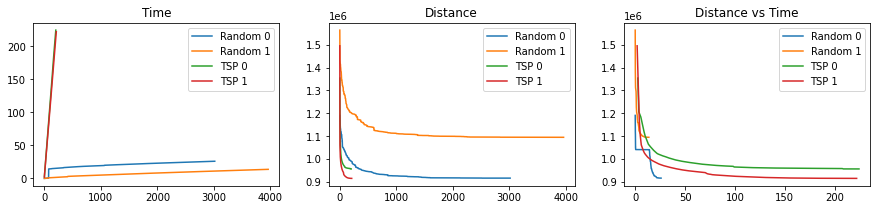

In [271]:
tsp = main()